In [1]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolAlign
import rdkit
print(rdkit.__version__)

2022.09.4


# Generate conformers

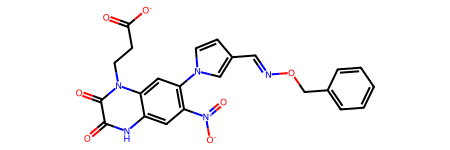

In [41]:
# modified CHEMBL12747, ionized
m = Chem.MolFromSmiles('O=C([O-])CCn1c(=O)c(=O)[nH]c2cc([N+](=O)[O-])c(-n3ccc(C=NOCc4ccccc4)c3)cc21')
m

In [23]:
mh = Chem.AddHs(m)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xd06f00d
ps.numThreads = 10
cids = rdDistGeom.EmbedMultipleConfs(mh,300,ps)
len(cids)

300

Remove Hs from the molecule at this point because they aren't 
particularly informative for the rest of the analysis and they
just make things more difficult


In [34]:
m3d = Chem.RemoveHs(mh)

# Direct alignment vs best alignment

Find a pair of conformers with a decent size mismatch between the direct alignment and the best alignment:

In [36]:
maxd = -100
for j in range(0,5):
    for i in range(j,len(cids)):
        d1 = rdMolAlign.AlignMol(m3d,m3d,prbCid=cids[i],refCid=cids[j])
        d2 = rdMolAlign.GetBestRMS(m3d,m3d,prbId=cids[i],refId=cids[j])
        delt = d1-d2
        if delt<-1e-5:
            print(f'ooops, {i}, {delt}')
        if delt>maxd:
            maxd = delt
            maxi = i
            maxj = j
d1 = rdMolAlign.AlignMol(m3d,m3d,prbCid=cids[maxi],refCid=cids[maxj])
d2 = rdMolAlign.GetBestRMS(m3d,m3d,prbId=cids[maxi],refId=cids[maxj])
print(maxi,maxd,d1,d2)

282 0.703433090406554 1.0038182177331938 0.3003851273604343


In [37]:
import py3Dmol
def drawit(m, cids=[-1], p=None, removeHs=True,colors=('cyanCarbon','redCarbon','blueCarbon','magentaCarbon','whiteCarbon','purpleCarbon')):
        if removeHs:
            m = Chem.RemoveHs(m)
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for i,cid in enumerate(cids):
            IPythonConsole.addMolToView(m,p,confId=cid)
        for i,cid in enumerate(cids):
            p.setStyle({'model':i,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()

In [39]:
d1 = rdMolAlign.AlignMol(m3d,m3d,prbCid=cids[maxi],refCid=cids[maxj])
drawit(m3d,[cids[maxj],cids[maxi]])


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [40]:
d2 = rdMolAlign.GetBestRMS(m3d,m3d,prbId=cids[maxi],refId=cids[maxj])
drawit(m3d,[cids[maxj],cids[maxi]])


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Cluster

Generate the RMSD distance matrix

In [28]:
dists = []
for i in range(len(cids)):
    for j in range(i):
        dists.append(rdMolAlign.GetBestRMS(m3d,m3d,i,j))

In [29]:
from rdkit.ML.Cluster import Butina
clusts = Butina.ClusterData(dists,len(cids),1.0,isDistData=True,reordering=True)
len(clusts)

53

To make visualization of the clusters work better, align all the conformers to the rigid 6-6 core:

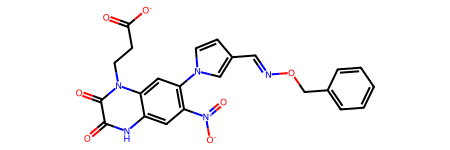

In [30]:
m

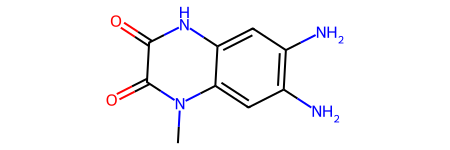

In [31]:
core = Chem.MolFromSmiles('O=C1C(=O)N(C)c2cc(N)c(N)cc2N1')
core

In [32]:
rdMolAlign.AlignMolConformers(m3d,atomIds = m3d.GetSubstructMatch(core))

In [33]:
centroids = [x[0] for x in clusts]
drawit(m3d,centroids[:5])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol